In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
import os
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-09-08 05:51:23.006969: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 05:51:23.235693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 05:51:24.165510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
file = '2013~2023 한국 기온,습도,풍속.csv'
file2 = '한국기후 평균 최고 최저.csv'

In [4]:
df = pd.read_csv(file, encoding = 'cp949')
df1 = pd.read_csv(file2, encoding = 'cp949', header = 0)
df1.head()

,\t\t지점번호,지점명,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,105,강릉,1970-01-01,3.2,10.3,-0.5
1,105,강릉,1970-01-02,1.8,5.1,-0.2
2,105,강릉,1970-01-03,-0.3,4.8,-2.2
3,105,강릉,1970-01-04,-5.9,-1.7,-12.6
4,105,강릉,1970-01-05,-7.9,-0.8,-14.7


In [5]:
df1.columns = ['지점번호', '지점명', '일시', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)']
df1 = df1.iloc[:, 2:]
df1.head()

,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,1970-01-01,3.2,10.3,-0.5
1,1970-01-02,1.8,5.1,-0.2
2,1970-01-03,-0.3,4.8,-2.2
3,1970-01-04,-5.9,-1.7,-12.6
4,1970-01-05,-7.9,-0.8,-14.7


In [6]:
df_korea = df.drop(['지점번호', '지점명'], axis = 1).groupby(['일시']).mean()
df_temp = df1.groupby(['일시']).mean()
df_korea.head(10)

,평균기온(℃),최고기온(℃),최저기온(℃),평균습도(%rh),평균풍속(m/s)
일시,,,,,
2013-01-01,-0.76250,4.43750,-6.21250,73.10000,2.33125
2013-01-02,-4.70000,0.54375,-8.98125,53.29375,3.58750
2013-01-03,-8.09375,-3.99375,-11.26250,48.90000,3.40625
2013-01-04,-6.74375,-1.15000,-11.61875,50.25000,2.03125
2013-01-05,-3.81250,1.75625,-9.41875,57.06250,2.28125
2013-01-06,-2.32500,2.52500,-5.73750,57.04375,1.96875
2013-01-07,-2.00625,3.35000,-6.72500,49.62500,1.95000
2013-01-08,-1.22500,3.76875,-5.28750,50.66250,2.15625
2013-01-09,-4.01875,-0.80625,-7.14375,45.38125,3.41250


In [7]:
filter1 = df_temp['최고기온(℃)'].isna() == True
df_temp['최고기온(℃)'][filter1] = 20.7875

In [8]:
filter2 = df_temp['최저기온(℃)'].isna() == True
df_temp['최저기온(℃)'][filter2] = 7.15625

In [9]:
df_korea = df_korea.reset_index()

In [10]:
df_korea['일시']  = pd.to_datetime(df_korea['일시'])
df_korea.set_index('일시', inplace = True)

In [11]:
dataset = df_temp.iloc[:, :]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(19585, 3)

In [12]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
print('Train Size :', train_size, 'Test Size : ', test_size)

Train Size : 15668 Test Size :  3917


In [13]:
scaler = MinMaxScaler(feature_range = (0 , 1))
scaled_data = scaler.fit_transform(np.array(data))

In [14]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(15668, 3)

In [15]:
x_train = []
y_train = []
time_step = 65
n_col = 3

for i in range(time_step, len(scaled_data)):
    print(time_step, i)
    x_train.append(scaled_data[i-time_step:i, :n_col])
    y_train.append(scaled_data[i, :n_col])
    if i <= time_step:
        print('x_train : ', x_train)
        print('y_train : ', y_train)

65 65
x_train :  [array([[0.28644888, 0.31922063, 0.28660807],
       [0.29945554, 0.29607384, 0.3198272 ],
       [0.25937689, 0.25388222, 0.26530612],
       [0.10027223, 0.10108409, 0.08580366],
       [0.02510587, 0.04731907, 0.        ],
       [0.24319419, 0.25754468, 0.20527335],
       [0.22837266, 0.23513038, 0.23596008],
       [0.23835451, 0.25388222, 0.23447043],
       [0.17211131, 0.16319953, 0.18948309],
       [0.20220811, 0.21432757, 0.19603754],
       [0.23275862, 0.25212423, 0.2215105 ],
       [0.33318209, 0.35159684, 0.2919708 ],
       [0.15366001, 0.17096396, 0.17488455],
       [0.09195402, 0.10225608, 0.10859526],
       [0.06488203, 0.05288602, 0.09742291],
       [0.05792498, 0.08980369, 0.04856249],
       [0.0738052 , 0.09449165, 0.07239684],
       [0.12885662, 0.18678582, 0.1084463 ],
       [0.17029643, 0.20773513, 0.16803218],
       [0.1822444 , 0.22121301, 0.17116043],
       [0.22081065, 0.27175505, 0.194101  ],
       [0.28055051, 0.32390858, 0.248

65 3651
65 3652
65 3653
65 3654
65 3655
65 3656
65 3657
65 3658
65 3659
65 3660
65 3661
65 3662
65 3663
65 3664
65 3665
65 3666
65 3667
65 3668
65 3669
65 3670
65 3671
65 3672
65 3673
65 3674
65 3675
65 3676
65 3677
65 3678
65 3679
65 3680
65 3681
65 3682
65 3683
65 3684
65 3685
65 3686
65 3687
65 3688
65 3689
65 3690
65 3691
65 3692
65 3693
65 3694
65 3695
65 3696
65 3697
65 3698
65 3699
65 3700
65 3701
65 3702
65 3703
65 3704
65 3705
65 3706
65 3707
65 3708
65 3709
65 3710
65 3711
65 3712
65 3713
65 3714
65 3715
65 3716
65 3717
65 3718
65 3719
65 3720
65 3721
65 3722
65 3723
65 3724
65 3725
65 3726
65 3727
65 3728
65 3729
65 3730
65 3731
65 3732
65 3733
65 3734
65 3735
65 3736
65 3737
65 3738
65 3739
65 3740
65 3741
65 3742
65 3743
65 3744
65 3745
65 3746
65 3747
65 3748
65 3749
65 3750
65 3751
65 3752
65 3753
65 3754
65 3755
65 3756
65 3757
65 3758
65 3759
65 3760
65 3761
65 3762
65 3763
65 3764
65 3765
65 3766
65 3767
65 3768
65 3769
65 3770
65 3771
65 3772
65 3773
65 3774
65 3775


65 7503
65 7504
65 7505
65 7506
65 7507
65 7508
65 7509
65 7510
65 7511
65 7512
65 7513
65 7514
65 7515
65 7516
65 7517
65 7518
65 7519
65 7520
65 7521
65 7522
65 7523
65 7524
65 7525
65 7526
65 7527
65 7528
65 7529
65 7530
65 7531
65 7532
65 7533
65 7534
65 7535
65 7536
65 7537
65 7538
65 7539
65 7540
65 7541
65 7542
65 7543
65 7544
65 7545
65 7546
65 7547
65 7548
65 7549
65 7550
65 7551
65 7552
65 7553
65 7554
65 7555
65 7556
65 7557
65 7558
65 7559
65 7560
65 7561
65 7562
65 7563
65 7564
65 7565
65 7566
65 7567
65 7568
65 7569
65 7570
65 7571
65 7572
65 7573
65 7574
65 7575
65 7576
65 7577
65 7578
65 7579
65 7580
65 7581
65 7582
65 7583
65 7584
65 7585
65 7586
65 7587
65 7588
65 7589
65 7590
65 7591
65 7592
65 7593
65 7594
65 7595
65 7596
65 7597
65 7598
65 7599
65 7600
65 7601
65 7602
65 7603
65 7604
65 7605
65 7606
65 7607
65 7608
65 7609
65 7610
65 7611
65 7612
65 7613
65 7614
65 7615
65 7616
65 7617
65 7618
65 7619
65 7620
65 7621
65 7622
65 7623
65 7624
65 7625
65 7626
65 7627


65 9411
65 9412
65 9413
65 9414
65 9415
65 9416
65 9417
65 9418
65 9419
65 9420
65 9421
65 9422
65 9423
65 9424
65 9425
65 9426
65 9427
65 9428
65 9429
65 9430
65 9431
65 9432
65 9433
65 9434
65 9435
65 9436
65 9437
65 9438
65 9439
65 9440
65 9441
65 9442
65 9443
65 9444
65 9445
65 9446
65 9447
65 9448
65 9449
65 9450
65 9451
65 9452
65 9453
65 9454
65 9455
65 9456
65 9457
65 9458
65 9459
65 9460
65 9461
65 9462
65 9463
65 9464
65 9465
65 9466
65 9467
65 9468
65 9469
65 9470
65 9471
65 9472
65 9473
65 9474
65 9475
65 9476
65 9477
65 9478
65 9479
65 9480
65 9481
65 9482
65 9483
65 9484
65 9485
65 9486
65 9487
65 9488
65 9489
65 9490
65 9491
65 9492
65 9493
65 9494
65 9495
65 9496
65 9497
65 9498
65 9499
65 9500
65 9501
65 9502
65 9503
65 9504
65 9505
65 9506
65 9507
65 9508
65 9509
65 9510
65 9511
65 9512
65 9513
65 9514
65 9515
65 9516
65 9517
65 9518
65 9519
65 9520
65 9521
65 9522
65 9523
65 9524
65 9525
65 9526
65 9527
65 9528
65 9529
65 9530
65 9531
65 9532
65 9533
65 9534
65 9535


65 12853
65 12854
65 12855
65 12856
65 12857
65 12858
65 12859
65 12860
65 12861
65 12862
65 12863
65 12864
65 12865
65 12866
65 12867
65 12868
65 12869
65 12870
65 12871
65 12872
65 12873
65 12874
65 12875
65 12876
65 12877
65 12878
65 12879
65 12880
65 12881
65 12882
65 12883
65 12884
65 12885
65 12886
65 12887
65 12888
65 12889
65 12890
65 12891
65 12892
65 12893
65 12894
65 12895
65 12896
65 12897
65 12898
65 12899
65 12900
65 12901
65 12902
65 12903
65 12904
65 12905
65 12906
65 12907
65 12908
65 12909
65 12910
65 12911
65 12912
65 12913
65 12914
65 12915
65 12916
65 12917
65 12918
65 12919
65 12920
65 12921
65 12922
65 12923
65 12924
65 12925
65 12926
65 12927
65 12928
65 12929
65 12930
65 12931
65 12932
65 12933
65 12934
65 12935
65 12936
65 12937
65 12938
65 12939
65 12940
65 12941
65 12942
65 12943
65 12944
65 12945
65 12946
65 12947
65 12948
65 12949
65 12950
65 12951
65 12952
65 12953
65 12954
65 12955
65 12956
65 12957
65 12958
65 12959
65 12960
65 12961
65 12962
65 12963
6

65 16252
65 16253
65 16254
65 16255
65 16256
65 16257
65 16258
65 16259
65 16260
65 16261
65 16262
65 16263
65 16264
65 16265
65 16266
65 16267
65 16268
65 16269
65 16270
65 16271
65 16272
65 16273
65 16274
65 16275
65 16276
65 16277
65 16278
65 16279
65 16280
65 16281
65 16282
65 16283
65 16284
65 16285
65 16286
65 16287
65 16288
65 16289
65 16290
65 16291
65 16292
65 16293
65 16294
65 16295
65 16296
65 16297
65 16298
65 16299
65 16300
65 16301
65 16302
65 16303
65 16304
65 16305
65 16306
65 16307
65 16308
65 16309
65 16310
65 16311
65 16312
65 16313
65 16314
65 16315
65 16316
65 16317
65 16318
65 16319
65 16320
65 16321
65 16322
65 16323
65 16324
65 16325
65 16326
65 16327
65 16328
65 16329
65 16330
65 16331
65 16332
65 16333
65 16334
65 16335
65 16336
65 16337
65 16338
65 16339
65 16340
65 16341
65 16342
65 16343
65 16344
65 16345
65 16346
65 16347
65 16348
65 16349
65 16350
65 16351
65 16352
65 16353
65 16354
65 16355
65 16356
65 16357
65 16358
65 16359
65 16360
65 16361
65 16362
6

In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_col))

In [18]:
x_train.shape, y_train.shape

((19520, 65, 3), (19520, 3))

In [22]:
m_lstm = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(x_train.shape[1], n_col),
                       activation = 'relu',return_sequences = True),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(50, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(50, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(32, return_sequences = False, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(n_col)
])

m_lstm.summary()
#kernel_regularizer="l2"
#kernel_regularizer = keras.regularizers.l2(0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 65, 50)            10800     
                                                                 
 lstm_7 (LSTM)               (None, 65, 64)            29440     
                                                                 
 lstm_8 (LSTM)               (None, 65, 50)            23000     
                                                                 
 lstm_9 (LSTM)               (None, 65, 64)            29440     
                                                                 
 lstm_10 (LSTM)              (None, 65, 50)            23000     
                                                                 
 lstm_11 (LSTM)              (None, 32)                10624     
                                                                 
 dense_3 (Dense)             (None, 32)               

In [23]:
m_lstm.compile(optimizer = tf.optimizers.RMSprop(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [24]:
h = m_lstm.fit(x_train, y_train, epochs = 30, shuffle=False, batch_size = 32)

Epoch 1/30
610/610 [==============================] - 32s 49ms/step - loss: 0.4261 - mae: 0.1617
Epoch 2/30
610/610 [==============================] - 34s 55ms/step - loss: 0.1157 - mae: 0.0900
Epoch 3/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0092 - mae: 0.0761
Epoch 4/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0085 - mae: 0.0710
Epoch 5/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0076 - mae: 0.0682
Epoch 6/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0071 - mae: 0.0660
Epoch 7/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0069 - mae: 0.0647
Epoch 8/30
610/610 [==============================] - 32s 53ms/step - loss: 0.0065 - mae: 0.0630
Epoch 9/30
610/610 [==============================] - 33s 53ms/step - loss: 0.0063 - mae: 0.0621
Epoch 10/30
610/610 [==============================] - 34s 56ms/step - loss: 0.0061 - mae: 0.0610
Epoch 11/30
610/610 [========

Text(0, 0.5, 'Losses')

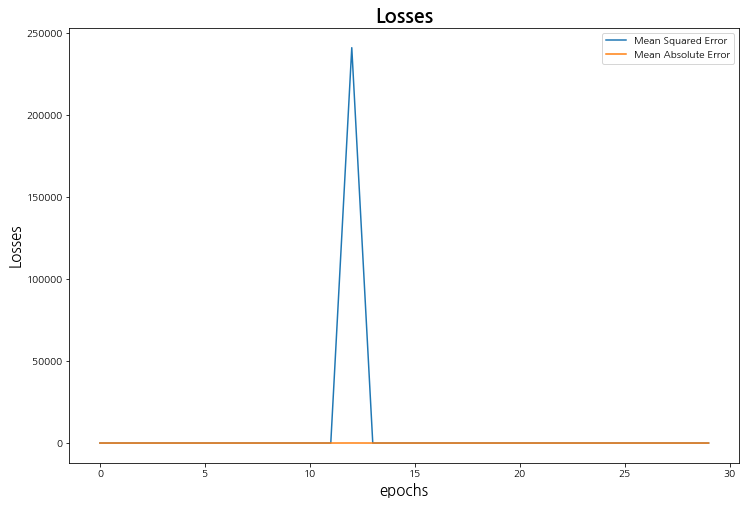

In [25]:
fig, axe = plt.subplots(figsize = (12, 8))
axe.plot(h.history['loss'])
axe.plot(h.history['mae'])
axe.legend(['Mean Squared Error', 'Mean Absolute Error'])
axe.set_title('Losses', size = 20, weight = 'bold')
axe.set_xlabel('epochs', size = 15)
axe.set_ylabel('Losses', size = 15)

In [26]:
#8/30
m_lstm.save('m8_lstm_RMSprop.h5')

In [27]:
m_lstm_RMSprop = tf.keras.models.load_model('m8_lstm_RMSprop.h5')

In [28]:
test_data = scaled_data[train_size - time_step:, :]

x_test = []
y_test = []

for i in range(time_step, len(test_data)):
    #print(time_step, i)
    x_test.append(test_data[i-time_step:i, 0:n_col])
    y_test.append(test_data[i, 0:n_col])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_col))

x_test

array([[[0.74153055, 0.75124524, 0.72441531],
        [0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        ...,
        [0.39398064, 0.40375037, 0.36317593],
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439]],

       [[0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        ...,
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793]],

       [[0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        [0.74863884, 0.76779959, 0.72605393],
        ...,
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793],
        [0.3761343 , 0.3891005 , 0.34693878]],

       ...,

       [[0.7993043 , 0.80383827, 0.78370326],
        [0.81019359, 0.82346909, 0.80560107],
        [0.79748941, 0

In [29]:
m_lstm_RMSprop.evaluate(x_test, y_test)

123/123 [==============================] - 3s 18ms/step - loss: 0.0033 - mae: 0.0475


[0.0032928558066487312, 0.047456178814172745]

In [30]:
pred = m_lstm_RMSprop.predict(x_test)
pred

123/123 [==============================] - 3s 18ms/step


array([[0.34708124, 0.35891098, 0.34665257],
       [0.32334855, 0.33533594, 0.32203653],
       [0.33890593, 0.35091862, 0.3375931 ],
       ...,
       [0.8318056 , 0.8022318 , 0.85595983],
       [0.8492293 , 0.81966215, 0.8720578 ],
       [0.8637744 , 0.83473295, 0.8854098 ]], dtype=float32)

In [31]:
pred = scaler.inverse_transform(pred)
print(pred.shape)
pred

(3917, 3)


array([[ 3.8368824e+00,  8.5620394e+00, -1.8258220e-02],
       [ 2.8561289e+00,  7.5562696e+00, -1.0510547e+00],
       [ 3.4990375e+00,  8.2210655e+00, -3.9835915e-01],
       ...,
       [ 2.3868116e+01,  2.7475214e+01,  2.1350365e+01],
       [ 2.4588150e+01,  2.8218838e+01,  2.2025774e+01],
       [ 2.5189228e+01,  2.8861795e+01,  2.2585974e+01]], dtype=float32)

In [32]:
y_test = scaler.inverse_transform(y_test)
y_test

array([[ 4.556250e+00,  9.287500e+00,  1.206250e+00],
       [ 5.037500e+00,  9.850000e+00, -6.250000e-03],
       [ 4.600000e+00,  8.412500e+00,  1.768750e+00],
       ...,
       [ 2.688750e+01,  3.100625e+01,  2.351875e+01],
       [ 2.740000e+01,  3.166250e+01,  2.434375e+01],
       [ 2.723750e+01,  3.121250e+01,  2.421250e+01]])

In [33]:
pred = pd.DataFrame(pred)
y_test = pd.DataFrame(y_test)

In [34]:
pred.columns = ['예측평균기온', '예측최고기온', '예측최저기온']
y_test.columns = ['실제평균기온', '실제최고기온', '실제최저기온']

In [35]:
df_pred = pd.concat((pred, y_test), axis = 1)
df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온', '예측최저기온', '실제최저기온']]
#df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온']]
df_pred

,예측평균기온,실제평균기온,예측최고기온,실제최고기온,예측최저기온,실제최저기온
0,3.836882,4.55625,8.562039,9.28750,-0.018258,1.20625
1,2.856129,5.03750,7.556270,9.85000,-1.051055,-0.00625
2,3.499038,4.60000,8.221066,8.41250,-0.398359,1.76875
3,2.751750,3.42500,7.452075,8.21875,-1.176710,-0.63750
4,2.028269,7.72500,6.727873,13.74375,-2.014332,1.75000
...,...,...,...,...,...,...
3912,21.960289,26.24375,25.738148,29.97500,19.409069,22.85625
3913,23.928879,25.86250,27.477154,29.23125,21.301977,23.14375
3914,23.868116,26.88750,27.475214,31.00625,21.350365,23.51875
3915,24.588150,27.40000,28.218838,31.66250,22.025774,24.34375


Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


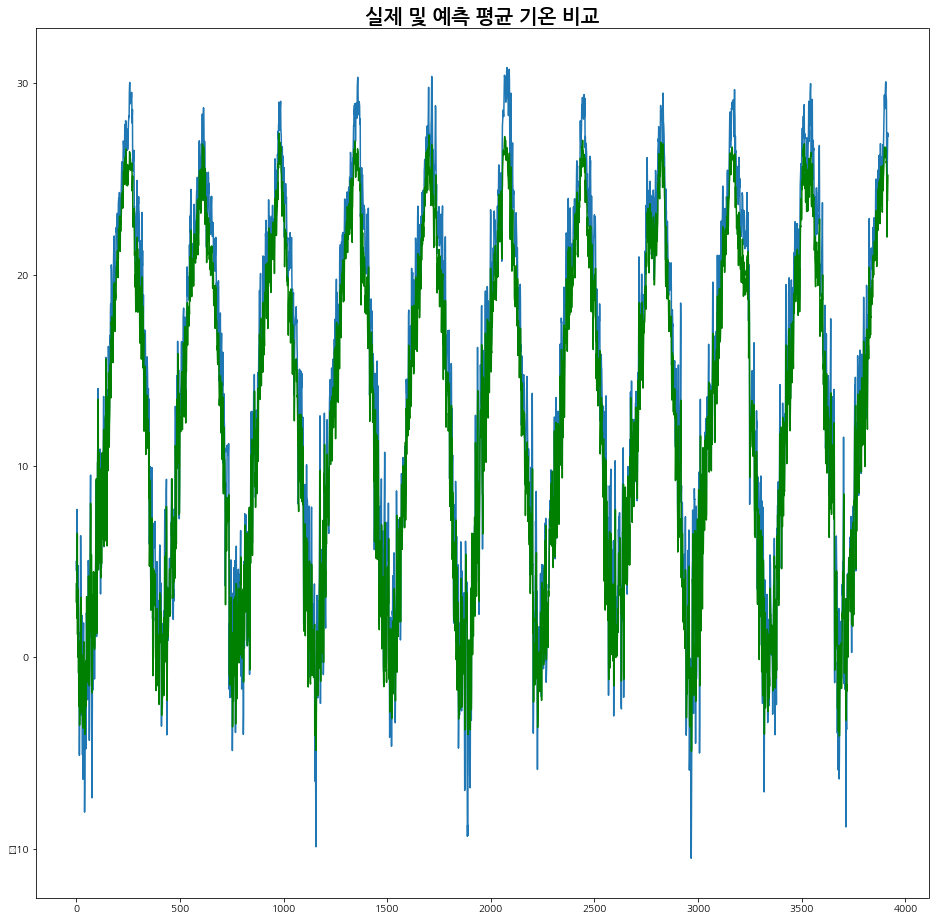

In [36]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제평균기온'])
axe.plot(df_pred['예측평균기온'], c = 'g')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

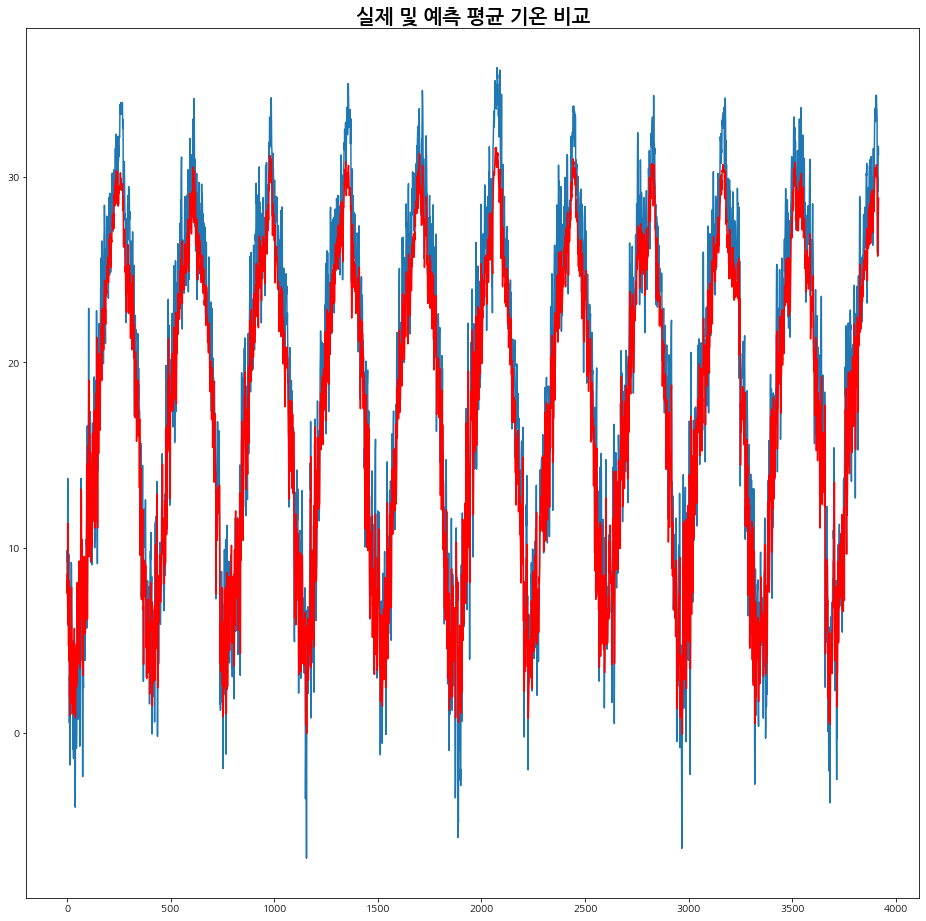

In [37]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최고기온'])
axe.plot(df_pred['예측최고기온'], c = 'r')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

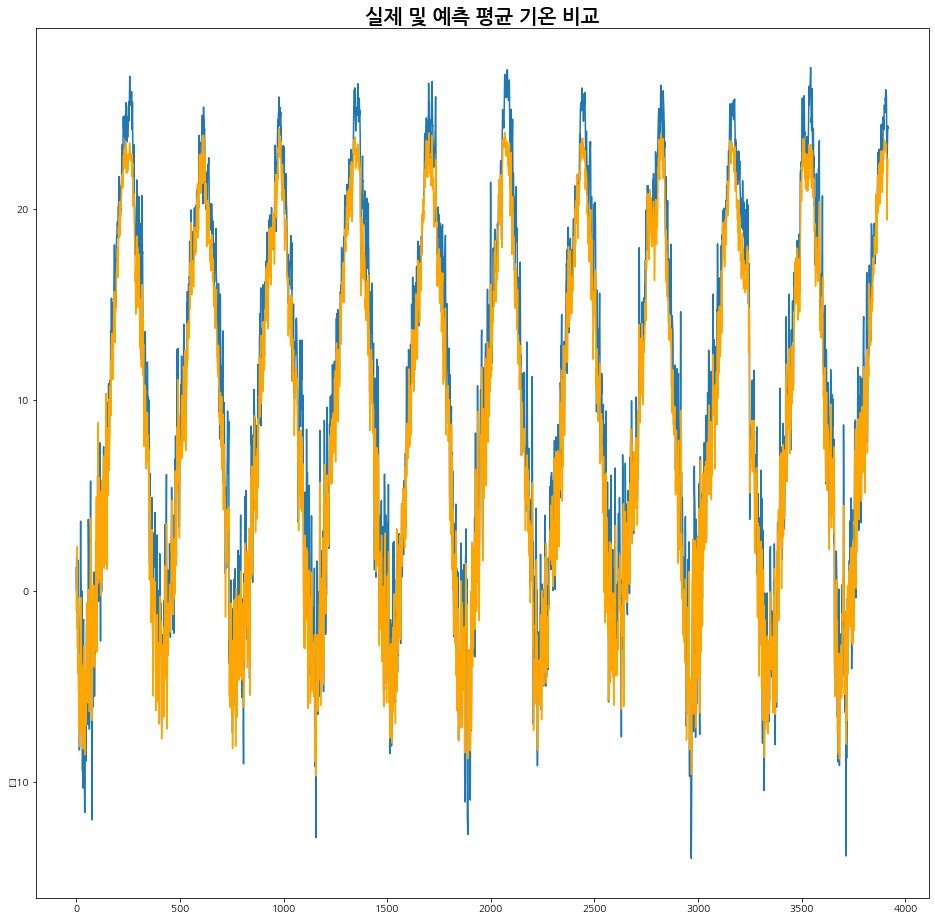

In [38]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최저기온'])
axe.plot(df_pred['예측최저기온'], c = 'orange')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

In [39]:
start_date = datetime.date(2023, 8, 16)
#print('언제의 대한민국 평균 기온을 알고 싶으신가요? (Ex. 2040-01-01, 형태로 적어주세요)')
year, month, day = map(int, input().split('-'))
target_date = datetime.date(year, month, day)

d_day = (target_date - start_date).days
print(d_day)

2025-08-15
730


In [40]:
list(x_test[-1][0])

[0.7974894131881426, 0.7981248168766482, 0.799791449426486]

In [42]:
last_array = []
for i in range(len(x_test[-1])):
    last_array.append(list(x_test[-1][i]))
len(last_array)
np.array(last_array)

array([[0.79748941, 0.79812482, 0.79979145],
       [0.78750756, 0.78523293, 0.79055564],
       [0.78871748, 0.77717551, 0.79413079],
       [0.77208106, 0.77234105, 0.7729778 ],
       [0.77283727, 0.77658951, 0.75495308],
       [0.82320024, 0.8448579 , 0.77387159],
       [0.84664247, 0.86595371, 0.81438999],
       [0.85012099, 0.86346323, 0.84120363],
       [0.85904416, 0.87884559, 0.8286906 ],
       [0.81261343, 0.77981248, 0.82809474],
       [0.76149425, 0.70216818, 0.80470728],
       [0.80490018, 0.7890419 , 0.80902726],
       [0.82698125, 0.82127161, 0.82064651],
       [0.8399879 , 0.84207442, 0.83345747],
       [0.84497883, 0.83899795, 0.83837331],
       [0.83514822, 0.77131556, 0.85282288],
       [0.87008469, 0.84837386, 0.87308208],
       [0.84694495, 0.81380018, 0.85297185],
       [0.85344828, 0.78757691, 0.89423507],
       [0.82879613, 0.777322  , 0.87546551],
       [0.86358137, 0.85701729, 0.86757039],
       [0.88384755, 0.87503662, 0.88559511],
       [0.

In [43]:
for i in range(time_step, d_day+ time_step):
    print(time_step, i)
    last_ar = np.array(last_array)[i-time_step:i, 0:n_col]
    print(last_ar)
    array = np.reshape(last_ar, (1, last_ar.shape[0], n_col))
    print(array.shape)
    last_array.append(list(m_lstm_RMSprop.predict(array)[0]))
    print(len(last_array))

65 65
[[0.79748941 0.79812482 0.79979145]
 [0.78750756 0.78523293 0.79055564]
 [0.78871748 0.77717551 0.79413079]
 [0.77208106 0.77234105 0.7729778 ]
 [0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.8070612

1/1 [==============================] - 0s 20ms/step
69
65 69
[[0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0

1/1 [==============================] - 0s 21ms/step
73
65 73
[[0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0

1/1 [==============================] - 0s 19ms/step
77
65 77
[[0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0

1/1 [==============================] - 0s 21ms/step
81
65 81
[[0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0

1/1 [==============================] - 0s 20ms/step
85
65 85
[[0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0

1/1 [==============================] - 0s 19ms/step
89
65 89
[[0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0

1/1 [==============================] - 0s 21ms/step
93
65 93
[[0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0

1/1 [==============================] - 0s 22ms/step
97
65 97
[[0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0

1/1 [==============================] - 0s 20ms/step
101
65 101
[[0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 

1/1 [==============================] - 0s 21ms/step
105
65 105
[[0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 

1/1 [==============================] - 0s 22ms/step
109
65 109
[[0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 

1/1 [==============================] - 0s 21ms/step
113
65 113
[[0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 

1/1 [==============================] - 0s 21ms/step
117
65 117
[[0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 

1/1 [==============================] - 0s 19ms/step
121
65 121
[[0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 

1/1 [==============================] - 0s 30ms/step
125
65 125
[[0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 

1/1 [==============================] - 0s 20ms/step
129
65 129
[[0.91727163 0.9003809  0.92730523]
 [0.86377442 0.83473295 0.88540977]
 [0.8106879  0.78673345 0.83881253]
 [0.77906132 0.75582963 0.80983979]
 [0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 

1/1 [==============================] - 0s 26ms/step
133
65 133
[[0.75057715 0.72825158 0.77640253]
 [0.72769785 0.71059412 0.74239326]
 [0.70836478 0.69878364 0.71398634]
 [0.69570458 0.69261038 0.69436777]
 [0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 

1/1 [==============================] - 0s 22ms/step
137
65 137
[[0.68835247 0.6901812  0.68188804]
 [0.68509948 0.69031584 0.67506063]
 [0.6803717  0.68817568 0.6682356 ]
 [0.67253542 0.68261957 0.65900105]
 [0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 

1/1 [==============================] - 0s 24ms/step
141
65 141
[[0.66188937 0.67418289 0.64715958]
 [0.64964551 0.66416818 0.63356632]
 [0.6378991  0.65451723 0.62028277]
 [0.62804061 0.64646    0.60887343]
 [0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 

1/1 [==============================] - 0s 21ms/step
145
65 145
[[0.62019664 0.63901711 0.59897673]
 [0.61401051 0.63288873 0.590904  ]
 [0.60967094 0.62832099 0.5850029 ]
 [0.6075933  0.62572557 0.5818488 ]
 [0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 

1/1 [==============================] - 0s 22ms/step
149
65 149
[[0.60601342 0.62366515 0.58007818]
 [0.60477048 0.62203681 0.57900459]
 [0.60384184 0.62076551 0.57840019]
 [0.60344326 0.62003148 0.57842416]
 [0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 

 [0.24734783 0.26654434 0.24650438]]
(1, 65, 3)
1/1 [==============================] - 0s 20ms/step
153
65 153
[[0.60465491 0.62081504 0.58010268]
 [0.60621589 0.62195492 0.58219749]
 [0.60510492 0.62071729 0.5817768 ]
 [0.60199869 0.61770767 0.57933336]
 [0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0

1/1 [==============================] - 0s 22ms/step
157
65 157
[[0.59925157 0.61509126 0.57710403]
 [0.59466547 0.61047065 0.57302982]
 [0.58839625 0.60382211 0.56723487]
 [0.58184278 0.59721649 0.56098533]
 [0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 

1/1 [==============================] - 0s 27ms/step
161
65 161
[[0.5754956  0.59083498 0.55489421]
 [0.569417   0.58472329 0.54904258]
 [0.56358999 0.57884943 0.54346079]
 [0.55766457 0.57284778 0.53782678]
 [0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 

1/1 [==============================] - 0s 20ms/step
165
65 165
[[0.55135328 0.5664221  0.53185451]
 [0.54465812 0.55957657 0.52552229]
 [0.53755677 0.55229801 0.51878232]
 [0.52965695 0.54418659 0.51126879]
 [0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 

1/1 [==============================] - 0s 23ms/step
169
65 169
[[0.52114213 0.53542501 0.5031355 ]
 [0.51283544 0.52685326 0.49518543]
 [0.5051946  0.51894194 0.48799688]
 [0.4972392  0.5106883  0.48061502]
 [0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 

1/1 [==============================] - 0s 21ms/step
173
65 173
[[0.4876965  0.50079471 0.47180051]
 [0.47654229 0.48924652 0.46141833]
 [0.46465522 0.47696289 0.45025092]
 [0.45201752 0.46395007 0.43834406]
 [0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 

1/1 [==============================] - 0s 21ms/step
177
65 177
[[0.43855557 0.45012751 0.42568743]
 [0.4269242  0.43818113 0.41483277]
 [0.41464427 0.42558008 0.40354532]
 [0.40079409 0.41159388 0.39089847]
 [0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 

1/1 [==============================] - 0s 20ms/step
181
65 181
[[0.38524961 0.39627314 0.3767851 ]
 [0.36892423 0.38013244 0.36190283]
 [0.3531408  0.36438963 0.34744948]
 [0.33859295 0.34987929 0.33420038]
 [0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 

1/1 [==============================] - 0s 22ms/step
185
65 185
[[0.32516962 0.33664265 0.32136989]
 [0.31268331 0.32469457 0.30786103]
 [0.30043036 0.31292835 0.29464129]
 [0.28830931 0.30125529 0.28154325]
 [0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 

1/1 [==============================] - 0s 20ms/step
189
65 189
[[0.27649087 0.28985083 0.26877883]
 [0.26508275 0.27881709 0.25654367]
 [0.25452882 0.26858819 0.24536297]
 [0.24455723 0.25896946 0.23495656]
 [0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 

1/1 [==============================] - 0s 22ms/step
193
65 193
[[0.23492762 0.25002804 0.22536978]
 [0.22630149 0.24203306 0.21692656]
 [0.21874598 0.23504913 0.2096957 ]
 [0.21266091 0.22925809 0.20366794]
 [0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 

1/1 [==============================] - 0s 19ms/step
197
65 197
[[0.20798558 0.22465652 0.19888499]
 [0.20457278 0.22113585 0.19579832]
 [0.20190951 0.21832258 0.19370213]
 [0.19997947 0.21663445 0.19228384]
 [0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 

1/1 [==============================] - 0s 22ms/step
201
65 201
[[0.19851878 0.21555427 0.19139001]
 [0.19758093 0.21509087 0.19112729]
 [0.1971713  0.21525672 0.19148335]
 [0.19741455 0.21618855 0.19259858]
 [0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 

1/1 [==============================] - 0s 19ms/step
205
65 205
[[0.19801037 0.2175009  0.1940513 ]
 [0.19893658 0.21884945 0.19586951]
 [0.20013395 0.22046703 0.19793805]
 [0.2017374  0.22245398 0.20030653]
 [0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 

1/1 [==============================] - 0s 20ms/step
209
65 209
[[0.20419185 0.22502729 0.20290767]
 [0.20744309 0.22833017 0.20626837]
 [0.21213137 0.23295733 0.21108879]
 [0.21811283 0.23876333 0.21724793]
 [0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 

(1, 65, 3)
1/1 [==============================] - 0s 21ms/step
213
65 213
[[0.22516865 0.24553609 0.22445557]
 [0.23252495 0.25254613 0.23189074]
 [0.23992372 0.25955743 0.23923257]
 [0.24734783 0.26654434 0.24650438]
 [0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.

1/1 [==============================] - 0s 20ms/step
217
65 217
[[0.25501168 0.27370003 0.25392121]
 [0.26282054 0.28110901 0.26162994]
 [0.27070969 0.28881589 0.2697708 ]
 [0.27893156 0.29681024 0.278247  ]
 [0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 

1/1 [==============================] - 0s 20ms/step
221
65 221
[[0.28689471 0.3044996  0.28642911]
 [0.29415569 0.31147543 0.29383755]
 [0.30063382 0.31765863 0.30028975]
 [0.3062914  0.32300875 0.30580401]
 [0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 

1/1 [==============================] - 0s 21ms/step
225
65 225
[[0.31072325 0.32721287 0.30963802]
 [0.31423196 0.33057278 0.31207848]
 [0.31720859 0.33334881 0.31412095]
 [0.31971964 0.33562976 0.31590232]
 [0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 

1/1 [==============================] - 0s 21ms/step
229
65 229
[[0.32174778 0.33760306 0.31724274]
 [0.32317212 0.33901453 0.3182351 ]
 [0.32378268 0.33953053 0.31877446]
 [0.32312563 0.33869943 0.31813422]
 [0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 

1/1 [==============================] - 0s 19ms/step
233
65 233
[[0.32234541 0.3377296  0.31734136]
 [0.32208222 0.33733404 0.31695753]
 [0.32294536 0.33823135 0.31740263]
 [0.32542196 0.34080219 0.31942236]
 [0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 

1/1 [==============================] - 0s 20ms/step
237
65 237
[[0.32919386 0.34472609 0.32271639]
 [0.33372462 0.34944826 0.32682037]
 [0.33919764 0.35518098 0.33187699]
 [0.34589958 0.36219904 0.33816028]
 [0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 

1/1 [==============================] - 0s 21ms/step
241
65 241
[[0.35358104 0.37020138 0.34544128]
 [0.36146176 0.37835574 0.35301143]
 [0.36949816 0.38669157 0.36066997]
 [0.37780511 0.3954007  0.3684755 ]
 [0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 

1/1 [==============================] - 0s 20ms/step
245
65 245
[[0.3854734  0.40347293 0.37559432]
 [0.39161894 0.40992406 0.3812499 ]
 [0.39640647 0.41491452 0.38561028]
 [0.40042305 0.41907477 0.38919407]
 [0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 

1/1 [==============================] - 0s 20ms/step
249
65 249
[[0.40415263 0.42293152 0.39243758]
 [0.40778539 0.42669201 0.39556026]
 [0.4114362  0.43047819 0.39868528]
 [0.41516858 0.43435237 0.40189981]
 [0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 

1/1 [==============================] - 0s 19ms/step
253
65 253
[[0.41871485 0.43803924 0.4049437 ]
 [0.421918   0.44137064 0.40766519]
 [0.42459735 0.44419029 0.40991646]
 [0.42676991 0.44650927 0.41171306]
 [0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 

1/1 [==============================] - 0s 20ms/step
257
65 257
[[0.42856097 0.44844982 0.41315627]
 [0.43011558 0.45015001 0.41438693]
 [0.43153676 0.45171854 0.41550058]
 [0.43287402 0.45319805 0.41654855]
 [0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 

1/1 [==============================] - 0s 19ms/step
261
65 261
[[0.43415424 0.45461813 0.41756046]
 [0.43536356 0.45596436 0.41851842]
 [0.43647557 0.45721233 0.41940278]
 [0.437437   0.4583219  0.42013872]
 [0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 

1/1 [==============================] - 0s 19ms/step
265
65 265
[[0.43822968 0.45926166 0.42071587]
 [0.43886954 0.46004191 0.42115402]
 [0.43939498 0.46070093 0.42149055]
 [0.43984231 0.46127197 0.42176127]
 [0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 

1/1 [==============================] - 0s 21ms/step
269
65 269
[[0.44022986 0.46177596 0.42198426]
 [0.44055906 0.46220577 0.4221673 ]
 [0.44082549 0.46256366 0.4223004 ]
 [0.44102705 0.4628444  0.42238474]
 [0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 

1/1 [==============================] - 0s 22ms/step
273
65 273
[[0.44116482 0.46304989 0.42241913]
 [0.44123417 0.46317157 0.42240196]
 [0.44121751 0.46319413 0.42231369]
 [0.44107699 0.46305442 0.42210668]
 [0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 

1/1 [==============================] - 0s 20ms/step
277
65 277
[[0.44071817 0.46267557 0.42166775]
 [0.44012788 0.46210307 0.42097515]
 [0.43935847 0.46134797 0.42010605]
 [0.43834475 0.46033499 0.41898477]
 [0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 

1/1 [==============================] - 0s 19ms/step
281
65 281
[[0.43708321 0.45907608 0.4176324 ]
 [0.43572542 0.45772979 0.41620147]
 [0.43444416 0.45646447 0.41485673]
 [0.43333647 0.45537528 0.41369581]
 [0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 

1/1 [==============================] - 0s 21ms/step
285
65 285
[[0.43243074 0.45448971 0.41274887]
 [0.43170056 0.45378241 0.41198999]
 [0.4311088  0.45321667 0.41138309]
 [0.43062633 0.45276216 0.41089463]
 [0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 

1/1 [==============================] - 0s 20ms/step
289
65 289
[[0.43023163 0.45239636 0.41049933]
 [0.42991117 0.45210612 0.4101792 ]
 [0.42964298 0.45186698 0.40991122]
 [0.42941582 0.45166847 0.40968508]
 [0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 

1/1 [==============================] - 0s 20ms/step
293
65 293
[[0.42922375 0.4515045  0.40949243]
 [0.42896882 0.45126247 0.40923071]
 [0.42848974 0.450809   0.40871382]
 [0.42767593 0.45002583 0.40785986]
 [0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 

1/1 [==============================] - 0s 21ms/step
297
65 297
[[0.42653662 0.44891343 0.40670252]
 [0.42515126 0.44754645 0.40532023]
 [0.42360425 0.44601122 0.40378964]
 [0.42195398 0.44436383 0.40216982]
 [0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 

1/1 [==============================] - 0s 22ms/step
301
65 301
[[0.42023128 0.44263682 0.40048867]
 [0.41842136 0.44081062 0.39873463]
 [0.41653544 0.43889803 0.39691651]
 [0.41458625 0.43691304 0.39504308]
 [0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 

1/1 [==============================] - 0s 20ms/step
305
65 305
[[0.41258183 0.43486223 0.39312357]
 [0.41054961 0.43277383 0.39118356]
 [0.40848118 0.43063974 0.38921821]
 [0.40636489 0.42845136 0.38721418]
 [0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 

1/1 [==============================] - 0s 20ms/step
309
65 309
[[0.40420762 0.42621601 0.38518292]
 [0.40202534 0.42395437 0.38313538]
 [0.39983901 0.4216851  0.38109404]
 [0.39764935 0.4194105  0.37905627]
 [0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 

1/1 [==============================] - 0s 19ms/step
313
65 313
[[0.39543378 0.41710779 0.37700331]
 [0.39311132 0.41469723 0.37486422]
 [0.39057425 0.41207036 0.37253565]
 [0.38775823 0.40916711 0.36996132]
 [0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 

1/1 [==============================] - 0s 21ms/step
317
65 317
[[0.38476732 0.40608615 0.36723256]
 [0.3817099  0.40293384 0.364447  ]
 [0.37857139 0.39969477 0.36159593]
 [0.37529913 0.39631295 0.35864019]
 [0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 

1/1 [==============================] - 0s 22ms/step
321
65 321
[[0.37186286 0.39275646 0.35555446]
 [0.36822087 0.38897941 0.35230172]
 [0.3643806  0.3849889  0.34889099]
 [0.36022785 0.38063675 0.34519872]
 [0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 

1/1 [==============================] - 0s 18ms/step
325
65 325
[[0.35572806 0.37588316 0.34119332]
 [0.35097191 0.37085846 0.33696491]
 [0.34592235 0.36553144 0.33247054]
 [0.34056669 0.35989046 0.32770026]
 [0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 

1/1 [==============================] - 0s 19ms/step
329
65 329
[[0.33490127 0.35392302 0.32266378]
 [0.3287468  0.34767479 0.31624213]
 [0.32202727 0.34094647 0.30894572]
 [0.31486207 0.33378312 0.30119622]
 [0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 

1/1 [==============================] - 0s 19ms/step
333
65 333
[[0.30734843 0.32627884 0.29312149]
 [0.29955715 0.31848899 0.28478417]
 [0.29153395 0.3104611  0.27624142]
 [0.28323936 0.30215049 0.26745784]
 [0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 

1/1 [==============================] - 0s 19ms/step
337
65 337
[[0.27476686 0.29364169 0.25852838]
 [0.26629594 0.28511032 0.24967377]
 [0.25762358 0.27635872 0.24064605]
 [0.24884084 0.26746583 0.2315615 ]
 [0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 

1/1 [==============================] - 0s 20ms/step
341
65 341
[[0.24035054 0.25884455 0.22281753]
 [0.23252127 0.25091076 0.21498871]
 [0.22570643 0.2440066  0.20837611]
 [0.21979778 0.23799974 0.20288381]
 [0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 

1/1 [==============================] - 0s 20ms/step
345
65 345
[[0.21473747 0.23285672 0.19838661]
 [0.21025296 0.22828555 0.19456944]
 [0.20655072 0.2241618  0.1916227 ]
 [0.20379752 0.22101092 0.18918931]
 [0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 

1/1 [==============================] - 0s 19ms/step
349
65 349
[[0.20178646 0.21885273 0.18774304]
 [0.20010963 0.21748778 0.18697664]
 [0.19891691 0.21668839 0.18676025]
 [0.1981405  0.21638021 0.18703854]
 [0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 

1/1 [==============================] - 0s 22ms/step
353
65 353
[[0.19776645 0.21652856 0.18774888]
 [0.19791102 0.21727896 0.18906718]
 [0.19864281 0.21859002 0.19074389]
 [0.19996992 0.2203497  0.19285682]
 [0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 

1/1 [==============================] - 0s 21ms/step
357
65 357
[[0.2021926  0.22265187 0.19596682]
 [0.20530254 0.22577059 0.19997315]
 [0.2094354  0.22983676 0.20501527]
 [0.21455799 0.23480317 0.21103323]
 [0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 

1/1 [==============================] - 0s 20ms/step
361
65 361
[[0.22065093 0.24064445 0.21793208]
 [0.22749707 0.24714309 0.22550026]
 [0.23450837 0.25375247 0.23306686]
 [0.24145338 0.26025507 0.24039003]
 [0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 

1/1 [==============================] - 0s 22ms/step
365
65 365
[[0.24821332 0.26652864 0.24734245]
 [0.25470504 0.27282348 0.25423563]
 [0.26115891 0.27906877 0.26104224]
 [0.26767212 0.28535047 0.26785463]
 [0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 

1/1 [==============================] - 0s 20ms/step
369
65 369
[[0.27436531 0.29178959 0.27481616]
 [0.2814292  0.29856417 0.2821607 ]
 [0.28870839 0.30551288 0.2897265 ]
 [0.29586551 0.31232512 0.29711938]
 [0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 

1/1 [==============================] - 0s 19ms/step
373
65 373
[[0.30170444 0.31784242 0.30299699]
 [0.30624413 0.32209381 0.30735737]
 [0.30979264 0.3254247  0.310332  ]
 [0.31287491 0.32847831 0.31228125]
 [0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 

1/1 [==============================] - 0s 20ms/step
377
65 377
[[0.31584379 0.33151063 0.31400758]
 [0.31852469 0.33422318 0.3154799 ]
 [0.32168511 0.33741334 0.31750888]
 [0.32512259 0.34090564 0.32002455]
 [0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 

1/1 [==============================] - 0s 20ms/step
381
65 381
[[0.32903272 0.34488237 0.32318372]
 [0.33334929 0.34926814 0.3268894 ]
 [0.33826584 0.35427925 0.33125889]
 [0.34362432 0.35975802 0.33612812]
 [0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 

1/1 [==============================] - 0s 20ms/step
385
65 385
[[0.34921736 0.36549246 0.34130239]
 [0.35480028 0.37122762 0.34659266]
 [0.36034659 0.37690997 0.35201895]
 [0.36594757 0.38266236 0.35755348]
 [0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 

1/1 [==============================] - 0s 19ms/step
389
65 389
[[0.37219432 0.38915694 0.36348188]
 [0.37905732 0.39634934 0.3698442 ]
 [0.38589391 0.40351456 0.37615049]
 [0.39225325 0.41016716 0.38201916]
 [0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 

1/1 [==============================] - 0s 22ms/step
393
65 393
[[0.39785975 0.41601551 0.38719344]
 [0.40273875 0.42109022 0.39165646]
 [0.40712774 0.42564645 0.39559704]
 [0.41113216 0.42980576 0.39912295]
 [0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 

1/1 [==============================] - 0s 20ms/step
397
65 397
[[0.41487145 0.43369645 0.40235645]
 [0.41846326 0.43743849 0.40543503]
 [0.42182523 0.44095427 0.40829122]
 [0.42502689 0.44431195 0.41099864]
 [0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 

1/1 [==============================] - 0s 22ms/step
401
65 401
[[0.42797157 0.44741538 0.41348076]
 [0.43063611 0.45025    0.41572595]
 [0.43286881 0.45268354 0.41752726]
 [0.43451172 0.45455244 0.4187389 ]
 [0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 

1/1 [==============================] - 0s 20ms/step
405
65 405
[[0.43567321 0.45593986 0.41950279]
 [0.43658626 0.4570713  0.42004037]
 [0.43740618 0.45810333 0.42050642]
 [0.43822429 0.45913008 0.42098463]
 [0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 

1/1 [==============================] - 0s 19ms/step
409
65 409
[[0.43907139 0.46018109 0.42150956]
 [0.43992504 0.46124262 0.42205739]
 [0.44073895 0.46225131 0.4225927 ]
 [0.44147626 0.46317193 0.42307496]
 [0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 

1/1 [==============================] - 0s 19ms/step
413
65 413
[[0.44212806 0.46399298 0.42349315]
 [0.44269159 0.46471095 0.42384404]
 [0.44319922 0.46535781 0.4241578 ]
 [0.4436841  0.46596843 0.42446214]
 [0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 

1/1 [==============================] - 0s 21ms/step
417
65 417
[[0.44414836 0.46654451 0.42476159]
 [0.44454068 0.46703446 0.4250074 ]
 [0.44482559 0.46739489 0.42517161]
 [0.44500905 0.46764055 0.42525274]
 [0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 

1/1 [==============================] - 0s 20ms/step
421
65 421
[[0.4451167  0.46779612 0.42527515]
 [0.44517288 0.46787378 0.42525882]
 [0.44520137 0.46787801 0.42520952]
 [0.44517905 0.46781009 0.42513096]
 [0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 

1/1 [==============================] - 0s 20ms/step
425
65 425
[[0.44508308 0.46765035 0.42500627]
 [0.44487292 0.4673599  0.42479438]
 [0.44455382 0.46697927 0.42447144]
 [0.44415352 0.46651801 0.42406917]
 [0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 

1/1 [==============================] - 0s 19ms/step
429
65 429
[[0.44369411 0.46599874 0.42360836]
 [0.44317004 0.4654215  0.42307788]
 [0.44256216 0.46477556 0.42245185]
 [0.44184795 0.46405318 0.42169166]
 [0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 

1/1 [==============================] - 0s 21ms/step
433
65 433
[[0.44104064 0.46325797 0.42082626]
 [0.44019309 0.46242538 0.4199307 ]
 [0.43940115 0.46165347 0.41909808]
 [0.43875349 0.46103111 0.41841263]
 [0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 

1/1 [==============================] - 0s 21ms/step
437
65 437
[[0.4382655  0.46056911 0.41788685]
 [0.43787149 0.46021068 0.41743594]
 [0.43744025 0.459829   0.4169156 ]
 [0.43686399 0.4592993  0.41625559]
 [0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 

1/1 [==============================] - 0s 21ms/step
441
65 441
[[0.4360489  0.45852515 0.41537625]
 [0.43495554 0.45746699 0.41424537]
 [0.43360627 0.45614487 0.41288549]
 [0.43206543 0.45462519 0.41135526]
 [0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 

1/1 [==============================] - 0s 21ms/step
445
65 445
[[0.43039563 0.45296976 0.40971351]
 [0.42863554 0.45121804 0.4079951 ]
 [0.42680779 0.44939339 0.40622485]
 [0.42493078 0.44751117 0.40442061]
 [0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 

1/1 [==============================] - 0s 21ms/step
449
65 449
[[0.42301214 0.44558075 0.40258706]
 [0.42103556 0.44358584 0.40070987]
 [0.41898412 0.44150883 0.39877135]
 [0.41688511 0.43937746 0.39679253]
 [0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 

1/1 [==============================] - 0s 20ms/step
453
65 453
[[0.41478461 0.4372341  0.39481682]
 [0.41268134 0.43507937 0.39284271]
 [0.41054603 0.4328824  0.39084303]
 [0.40837601 0.43064427 0.38881785]
 [0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 

1/1 [==============================] - 0s 20ms/step
457
65 457
[[0.40617791 0.42837158 0.38677132]
 [0.40396121 0.42607605 0.38471198]
 [0.40173653 0.42376766 0.38265222]
 [0.39946261 0.42140666 0.38054973]
 [0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 

1/1 [==============================] - 0s 20ms/step
461
65 461
[[0.39710847 0.41896284 0.37838024]
 [0.39457819 0.41634101 0.37605858]
 [0.39181837 0.41348916 0.37353319]
 [0.38877895 0.41035712 0.37075716]
 [0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 

1/1 [==============================] - 0s 21ms/step
465
65 465
[[0.38555297 0.40703428 0.3678146 ]
 [0.38225842 0.40363717 0.3648169 ]
 [0.37882271 0.40008616 0.3617093 ]
 [0.37519017 0.39632201 0.35844332]
 [0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 

1/1 [==============================] - 0s 21ms/step
469
65 469
[[0.37133756 0.39232004 0.35500404]
 [0.36718714 0.38800359 0.35131863]
 [0.36266387 0.3832961  0.34732318]
 [0.3576819  0.37807995 0.34292537]
 [0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 

1/1 [==============================] - 0s 22ms/step
473
65 473
[[0.35231707 0.37240866 0.33816314]
 [0.34662059 0.36638921 0.33311096]
 [0.34054488 0.35997561 0.32772154]
 [0.33408642 0.35316607 0.32198864]
 [0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 

1/1 [==============================] - 0s 21ms/step
477
65 477
[[0.32701182 0.34602726 0.31441462]
 [0.31927517 0.33826822 0.30603009]
 [0.31110027 0.3300885  0.29720312]
 [0.30259833 0.32158402 0.28808528]
 [0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 

1/1 [==============================] - 0s 22ms/step
481
65 481
[[0.2938875  0.31286594 0.27878708]
 [0.28493664 0.30389369 0.2692908 ]
 [0.27572602 0.29464453 0.2595779 ]
 [0.26652858 0.28538167 0.24994954]
 [0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 

1/1 [==============================] - 0s 20ms/step
485
65 485
[[0.25721064 0.27597412 0.24025176]
 [0.24770728 0.26635411 0.23041907]
 [0.23872277 0.25723851 0.22115928]
 [0.23064989 0.24903837 0.21309941]
 [0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 

1/1 [==============================] - 0s 22ms/step
489
65 489
[[0.22365183 0.24192932 0.20635052]
 [0.21764039 0.23582509 0.20078565]
 [0.21246533 0.23054948 0.19622959]
 [0.20804985 0.22579551 0.19249736]
 [0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 

1/1 [==============================] - 0s 21ms/step
493
65 493
[[0.20465247 0.22163272 0.18945746]
 [0.20207971 0.21871123 0.18728772]
 [0.2000367  0.21689418 0.18612215]
 [0.19843805 0.21563792 0.18549716]
 [0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 

1/1 [==============================] - 0s 21ms/step
497
65 497
[[0.19732244 0.21494967 0.18544561]
 [0.19657004 0.21468067 0.18577324]
 [0.19634351 0.2150183  0.18668689]
 [0.19660997 0.21592215 0.1881195 ]
 [0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 

1/1 [==============================] - 0s 19ms/step
501
65 501
[[0.19727732 0.21727338 0.18997544]
 [0.19847643 0.21906754 0.19199456]
 [0.20059016 0.22130027 0.19489846]
 [0.20351976 0.22424003 0.19864373]
 [0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 

1/1 [==============================] - 0s 21ms/step
505
65 505
[[0.20730983 0.22796786 0.20321846]
 [0.21199545 0.23250386 0.20867619]
 [0.21758798 0.23786277 0.21499375]
 [0.22406545 0.24402273 0.22215399]
 [0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 

1/1 [==============================] - 0s 21ms/step
509
65 509
[[0.23108807 0.25066343 0.2297712 ]
 [0.23824373 0.2573829  0.23735806]
 [0.24525905 0.26391494 0.24460368]
 [0.25205746 0.2703101  0.25160027]
 [0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 

1/1 [==============================] - 0s 21ms/step
513
65 513
[[0.25866205 0.27672163 0.25857544]
 [0.26532319 0.28316152 0.26553509]
 [0.27212253 0.28971502 0.2726078 ]
 [0.27915302 0.2964631  0.27990669]
 [0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 

1/1 [==============================] - 0s 19ms/step
517
65 517
[[0.28649601 0.30347961 0.28754398]
 [0.29384634 0.31047621 0.2951678 ]
 [0.30018559 0.31648466 0.30159137]
 [0.30517271 0.32118377 0.30641758]
 [0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 

1/1 [==============================] - 0s 21ms/step
521
65 521
[[0.30908832 0.32486546 0.30985415]
 [0.3124527  0.32811239 0.31214207]
 [0.31561971 0.33132982 0.31406265]
 [0.3186973  0.33446717 0.31586587]
 [0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 

1/1 [==============================] - 0s 21ms/step
525
65 525
[[0.32184502 0.33763874 0.31778896]
 [0.32520139 0.34105232 0.32014501]
 [0.32892931 0.34484974 0.32305342]
 [0.33321303 0.34920219 0.32667834]
 [0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 

1/1 [==============================] - 0s 22ms/step
529
65 529
[[0.33796668 0.35403082 0.33088309]
 [0.34324592 0.35941452 0.33566299]
 [0.34891471 0.3652145  0.34088981]
 [0.35468477 0.37113473 0.34630373]
 [0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 

(1, 65, 3)
1/1 [==============================] - 0s 20ms/step
533
65 533
[[0.36038855 0.37698373 0.35180062]
 [0.36592993 0.38265321 0.35727847]
 [0.37160981 0.38849828 0.36285204]
 [0.37801588 0.3951906  0.36886406]
 [0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.

1/1 [==============================] - 0s 20ms/step
537
65 537
[[0.38483441 0.40234187 0.37517172]
 [0.39148813 0.40931049 0.38131261]
 [0.39757353 0.41566357 0.38693631]
 [0.40287107 0.42117551 0.39182591]
 [0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 

1/1 [==============================] - 0s 19ms/step
541
65 541
[[0.4075371  0.42602316 0.39605135]
 [0.41165569 0.43030262 0.39969712]
 [0.41539434 0.43419546 0.40293831]
 [0.41897929 0.43793488 0.40600538]
 [0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 

1/1 [==============================] - 0s 22ms/step
545
65 545
[[0.42238298 0.44149679 0.40889663]
 [0.42566955 0.44494563 0.4116801 ]
 [0.42871869 0.44815272 0.41424954]
 [0.43141702 0.45103496 0.41650462]
 [0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 

1/1 [==============================] - 0s 20ms/step
549
65 549
[[0.4334451  0.45329705 0.41805685]
 [0.43482688 0.45492023 0.41900307]
 [0.43583137 0.45615983 0.41960031]
 [0.43671361 0.45726749 0.4200958 ]
 [0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 

1/1 [==============================] - 0s 20ms/step
553
65 553
[[0.43759012 0.45836326 0.42060596]
 [0.4384847  0.45946652 0.42115688]
 [0.43938592 0.46056718 0.42173553]
 [0.44025201 0.46163049 0.42230338]
 [0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 

1/1 [==============================] - 0s 19ms/step
557
65 557
[[0.44106123 0.46263614 0.42283356]
 [0.44179052 0.46354744 0.42330736]
 [0.44243398 0.46436211 0.42371565]
 [0.44300523 0.46508881 0.42407256]
 [0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 

1/1 [==============================] - 0s 20ms/step
561
65 561
[[0.44353864 0.46576425 0.42440695]
 [0.44404495 0.46639702 0.42473167]
 [0.44451904 0.46698275 0.42504102]
 [0.44491157 0.46747449 0.42528552]
 [0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 

1/1 [==============================] - 0s 21ms/step
565
65 565
[[0.44519517 0.46783546 0.42544788]
 [0.44538197 0.46808299 0.42553306]
 [0.44549757 0.46824923 0.42556012]
 [0.44556361 0.46833742 0.42555052]
 [0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 

1/1 [==============================] - 0s 21ms/step
569
65 569
[[0.44560024 0.46835217 0.42550689]
 [0.4455955  0.46830624 0.42544091]
 [0.44553024 0.46818319 0.42533803]
 [0.44535956 0.46792856 0.42516589]
 [0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 

1/1 [==============================] - 0s 21ms/step
573
65 573
[[0.44506469 0.46756148 0.42487335]
 [0.44467428 0.46710762 0.42448616]
 [0.44422755 0.46659601 0.42404425]
 [0.44373119 0.46604055 0.42354774]
 [0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 

1/1 [==============================] - 0s 20ms/step
577
65 577
[[0.44316456 0.4654249  0.42297465]
 [0.44250923 0.46473822 0.4223007 ]
 [0.44176611 0.46399221 0.42151529]
 [0.4409672  0.46320757 0.42066568]
 [0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 

1/1 [==============================] - 0s 22ms/step
581
65 581
[[0.44018534 0.46244475 0.41984177]
 [0.4395045  0.46178719 0.4191215 ]
 [0.43896064 0.46126798 0.41853946]
 [0.43849811 0.46085042 0.41800249]
 [0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 

1/1 [==============================] - 0s 20ms/step
585
65 585
[[0.43801025 0.4604134  0.41742462]
 [0.43740231 0.45985305 0.41672987]
 [0.43657964 0.45907158 0.41584021]
 [0.43549055 0.45801738 0.41471207]
 [0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 

1/1 [==============================] - 0s 21ms/step
589
65 589
[[0.4341484  0.45670223 0.41335911]
 [0.432612   0.4551869  0.41183406]
 [0.43094066 0.45353019 0.41019142]
 [0.42917469 0.45177284 0.40846854]
 [0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 

1/1 [==============================] - 0s 20ms/step
593
65 593
[[0.42733899 0.44994038 0.40669137]
 [0.42545211 0.44804877 0.4048785 ]
 [0.42352188 0.44610745 0.40303373]
 [0.4215413  0.44410864 0.40115333]
 [0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 

1/1 [==============================] - 0s 20ms/step
597
65 597
[[0.41948533 0.44202778 0.39921176]
 [0.4173775  0.43988895 0.3972255 ]
 [0.41526741 0.43773749 0.39524233]
 [0.41315699 0.43557712 0.39326268]
 [0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 

1/1 [==============================] - 0s 22ms/step
601
65 601
[[0.41101599 0.43337536 0.39125872]
 [0.40883687 0.43112877 0.38922536]
 [0.4066267  0.42884421 0.38716847]
 [0.40439627 0.42653477 0.38509595]
 [0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 

1/1 [==============================] - 0s 22ms/step
605
65 605
[[0.40215871 0.42421344 0.38302422]
 [0.39987752 0.42184576 0.38091558]
 [0.39752373 0.41940224 0.37874615]
 [0.39499637 0.41678336 0.3764267 ]
 [0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 

1/1 [==============================] - 0s 25ms/step
609
65 609
[[0.39224392 0.41393909 0.37390852]
 [0.3892121  0.41081434 0.37113917]
 [0.38598254 0.40748811 0.36819339]
 [0.38268453 0.40408799 0.36519223]
 [0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 

1/1 [==============================] - 0s 19ms/step
613
65 613
[[0.37924194 0.40053013 0.36207765]
 [0.37560311 0.39676031 0.35880554]
 [0.37174714 0.39275485 0.35536236]
 [0.36759862 0.38843936 0.35167825]
 [0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 

1/1 [==============================] - 0s 22ms/step
617
65 617
[[0.36306748 0.38372317 0.34767562]
 [0.35806951 0.37850028 0.34326935]
 [0.35266906 0.3727906  0.33847696]
 [0.34693056 0.36672533 0.33338949]
 [0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 

1/1 [==============================] - 0s 22ms/step
621
65 621
[[0.34081843 0.36027256 0.32796821]
 [0.33433166 0.35343412 0.32220906]
 [0.3272289  0.34625348 0.3146553 ]
 [0.31945351 0.33845311 0.30622759]
 [0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 

1/1 [==============================] - 0s 22ms/step
625
65 625
[[0.3112247  0.33021784 0.29734182]
 [0.30266517 0.32165518 0.28816253]
 [0.29389244 0.31287453 0.27879742]
 [0.28488892 0.3038497  0.26924416]
 [0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 

1/1 [==============================] - 0s 22ms/step
629
65 629
[[0.27562878 0.29454976 0.25947964]
 [0.26637867 0.28523299 0.24979758]
 [0.25700691 0.27577025 0.24004492]
 [0.24744642 0.26609182 0.23015404]
 [0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 

1/1 [==============================] - 0s 21ms/step
633
65 633
[[0.23844579 0.25696033 0.22087647]
 [0.23038471 0.24877179 0.21283457]
 [0.22339296 0.2416667  0.20610271]
 [0.21739121 0.23557228 0.20055462]
 [0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 

1/1 [==============================] - 0s 22ms/step
637
65 637
[[0.21222779 0.23030964 0.19601305]
 [0.20786753 0.22555003 0.1923103 ]
 [0.20448023 0.22141179 0.18927518]
 [0.20193255 0.21852079 0.18714564]
 [0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 

1/1 [==============================] - 0s 20ms/step
641
65 641
[[0.19988972 0.21674019 0.18600561]
 [0.19830793 0.2155053  0.18540497]
 [0.19720173 0.21482944 0.18536307]
 [0.19646691 0.21458125 0.18571515]
 [0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 

1/1 [==============================] - 0s 20ms/step
645
65 645
[[0.1962676  0.21495271 0.18666449]
 [0.19654816 0.2158742  0.18812057]
 [0.19723246 0.21724588 0.18999436]
 [0.19844219 0.21905503 0.19202672]
 [0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 

1/1 [==============================] - 0s 20ms/step
649
65 649
[[0.20057306 0.22129965 0.19494757]
 [0.20351195 0.22424671 0.19869274]
 [0.20732051 0.22799101 0.20328313]
 [0.21200758 0.23252839 0.20873874]
 [0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 

1/1 [==============================] - 0s 21ms/step
653
65 653
[[0.21758494 0.23787034 0.21503043]
 [0.22401792 0.24398395 0.22213186]
 [0.23101364 0.25059915 0.22971654]
 [0.2381649  0.25731483 0.23729478]
 [0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 

1/1 [==============================] - 0s 22ms/step
657
65 657
[[0.24518535 0.26385269 0.24454524]
 [0.25199255 0.27024886 0.25154164]
 [0.25860697 0.27667099 0.25852534]
 [0.26528162 0.2831246  0.26549786]
 [0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 

1/1 [==============================] - 0s 21ms/step
661
65 661
[[0.27209377 0.28969121 0.27258408]
 [0.27913842 0.29645371 0.2798959 ]
 [0.28649187 0.30347994 0.28754613]
 [0.29384574 0.31047934 0.2951749 ]
 [0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 

1/1 [==============================] - 0s 22ms/step
665
65 665
[[0.30018318 0.3164854  0.30159795]
 [0.30516988 0.32118475 0.30642045]
 [0.30908805 0.32486987 0.30985501]
 [0.31246126 0.32812682 0.31214741]
 [0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 

1/1 [==============================] - 0s 21ms/step
669
65 669
[[0.31563973 0.33135214 0.31408191]
 [0.31873408 0.33450741 0.31589925]
 [0.32188413 0.33768174 0.3178224 ]
 [0.32524377 0.34109879 0.32017946]
 [0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 

1/1 [==============================] - 0s 20ms/step
673
65 673
[[0.32897225 0.34489679 0.32308683]
 [0.3332572  0.34925103 0.3267107 ]
 [0.33800915 0.35407725 0.33091459]
 [0.3432889  0.3594608  0.33569556]
 [0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 

1/1 [==============================] - 0s 20ms/step
677
65 677
[[0.34896606 0.36526915 0.3409301 ]
 [0.35474759 0.37120098 0.34635463]
 [0.36046386 0.37706301 0.35186082]
 [0.36601025 0.38273725 0.35734063]
 [0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 

1/1 [==============================] - 0s 21ms/step
681
65 681
[[0.37166756 0.38855609 0.36290103]
 [0.37805143 0.39522448 0.36889613]
 [0.38486588 0.40237194 0.37520027]
 [0.39152926 0.40935063 0.3813504 ]
 [0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 

1/1 [==============================] - 0s 20ms/step
685
65 685
[[0.39762861 0.41571847 0.38698739]
 [0.40293941 0.42124411 0.39189029]
 [0.40761486 0.42610177 0.3961243 ]
 [0.41173574 0.43038386 0.39977258]
 [0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 

1/1 [==============================] - 0s 20ms/step
689
65 689
[[0.41547298 0.43427512 0.40301234]
 [0.41905788 0.43801489 0.40607959]
 [0.42246324 0.44157875 0.40897185]
 [0.42575023 0.44502825 0.4117558 ]
 [0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 

1/1 [==============================] - 0s 21ms/step
693
65 693
[[0.42880026 0.4482365  0.41432613]
 [0.43149149 0.4511134  0.41657072]
 [0.43349999 0.45335725 0.41810268]
 [0.43486226 0.45496181 0.41902936]
 [0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 

1/1 [==============================] - 0s 23ms/step
697
65 697
[[0.43585622 0.45619097 0.41961628]
 [0.43673715 0.45729771 0.42010987]
 [0.43761659 0.45839617 0.42062306]
 [0.43851441 0.4595027  0.42117733]
 [0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 

1/1 [==============================] - 0s 21ms/step
701
65 701
[[0.43941665 0.46060404 0.42175758]
 [0.44028142 0.46166551 0.4223249 ]
 [0.4410888  0.46266901 0.42285347]
 [0.44181594 0.46357819 0.42332542]
 [0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 

1/1 [==============================] - 0s 23ms/step
705
65 705
[[0.44245747 0.46439072 0.42373198]
 [0.44302815 0.4651168  0.4240886 ]
 [0.44356242 0.46579304 0.42442369]
 [0.44406906 0.46642593 0.42474902]
 [0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 

1/1 [==============================] - 0s 22ms/step
709
65 709
[[0.44454297 0.46701154 0.42505836]
 [0.44493482 0.46750224 0.42530233]
 [0.44521719 0.46786186 0.42546386]
 [0.44540319 0.46810848 0.42554837]
 [0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 

1/1 [==============================] - 0s 21ms/step
713
65 713
[[0.44551831 0.46827421 0.42557496]
 [0.44558153 0.46835867 0.42556268]
 [0.44561511 0.46837041 0.42551625]
 [0.44561082 0.46832484 0.42545068]
 [0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 

(1, 65, 3)
1/1 [==============================] - 0s 20ms/step
717
65 717
[[0.44554782 0.46820408 0.42534983]
 [0.44537941 0.46795192 0.42517954]
 [0.44508567 0.46758556 0.42488855]
 [0.44469544 0.46713173 0.42450178]
 [0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.

1/1 [==============================] - 0s 22ms/step
721
65 721
[[0.44424844 0.46661964 0.42405993]
 [0.44375196 0.4660638  0.42356354]
 [0.44318566 0.46544835 0.42299128]
 [0.44253153 0.46476236 0.42231911]
 [0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 

1/1 [==============================] - 0s 20ms/step
725
65 725
[[0.44179085 0.46401769 0.42153776]
 [0.44099429 0.46323538 0.42069036]
 [0.44021383 0.46247402 0.41986787]
 [0.43953332 0.46181655 0.41914773]
 [0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 

1/1 [==============================] - 0s 20ms/step
729
65 729
[[0.43898866 0.4612968  0.41856456]
 [0.43852314 0.46087697 0.41802329]
 [0.43803173 0.46043637 0.41744179]
 [0.43742007 0.45987219 0.41674328]
 [0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 

1/1 [==============================] - 0s 20ms/step
733
65 733
[[0.43659288 0.45908624 0.41584939]
 [0.43550012 0.45802817 0.41471785]
 [0.43415532 0.45671025 0.41336268]
 [0.43261692 0.45519283 0.41183591]
 [0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 

1/1 [==============================] - 0s 31ms/step
737
65 737
[[0.43094403 0.4535346  0.41019201]
 [0.42917681 0.45177579 0.40846807]
 [0.42733982 0.44994199 0.40668988]
 [0.42545176 0.44804913 0.40487599]
 [0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 

1/1 [==============================] - 0s 20ms/step
741
65 741
[[0.42352003 0.44610623 0.40303016]
 [0.42153779 0.44410563 0.40114826]
 [0.41948038 0.44202334 0.39920551]
 [0.41737202 0.43988398 0.39721882]
 [0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 

1/1 [==============================] - 0s 22ms/step
745
65 745
[[0.41526133 0.43773171 0.39523518]
 [0.41315034 0.43557084 0.39325511]
 [0.41100907 0.43336874 0.39125115]
 [0.40882924 0.43112132 0.38921714]
 [0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 

(1, 65, 3)
1/1 [==============================] - 0s 21ms/step
749
65 749
[[0.40661797 0.42883551 0.38715929]
 [0.40438628 0.42652482 0.38508564]
 [0.40214798 0.42420271 0.38301343]
 [0.39986551 0.42183375 0.38090366]
 [0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.

1/1 [==============================] - 0s 21ms/step
753
65 753
[[0.39750895 0.4193874  0.37873185]
 [0.39497837 0.4167653  0.37640947]
 [0.39222381 0.41391885 0.37388945]
 [0.389189   0.41079116 0.37111741]
 [0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 

1/1 [==============================] - 0s 22ms/step
757
65 757
[[0.38595766 0.40746298 0.36817002]
 [0.38265753 0.40406072 0.36516714]
 [0.37921244 0.40050006 0.36205053]
 [0.37557063 0.39672709 0.35877591]
 [0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 

1/1 [==============================] - 0s 21ms/step
761
65 761
[[0.3717114  0.39271814 0.35533029]
 [0.36755791 0.3883974  0.35164189]
 [0.36302027 0.38367438 0.3476339 ]
 [0.35801467 0.37844279 0.34322077]
 [0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 

1/1 [==============================] - 0s 23ms/step
765
65 765
[[0.35260734 0.37272587 0.3384223 ]
 [0.34686193 0.36665353 0.33332857]
 [0.34074324 0.36019388 0.32790142]
 [0.33424988 0.3533482  0.32213694]
 [0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 

1/1 [==============================] - 0s 21ms/step
769
65 769
[[0.32713678 0.34616119 0.31455544]
 [0.31935033 0.33835009 0.30611646]
 [0.31111309 0.3301065  0.29722208]
 [0.30254689 0.32153708 0.28803605]
 [0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 

1/1 [==============================] - 0s 21ms/step
773
65 773
[[0.29376799 0.31274998 0.27866533]
 [0.28475764 0.303718   0.26910532]
 [0.2754944  0.29441473 0.25933874]
 [0.26624152 0.28509471 0.24965487]
 [0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 

1/1 [==============================] - 0s 22ms/step
777
65 777
[[0.25686249 0.27562425 0.23989528]
 [0.24729988 0.26594344 0.23000301]
 [0.23830965 0.25682199 0.22073676]
 [0.23026541 0.24865088 0.21271624]
 [0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 [0.21767053 0.23795241 0.21512744]
 [0.22411478 0.24407607 0.22223942]
 [0.23111111 0.25069129 0.22982225]
 [0.23825908 0.25740337 0.23739444]
 

1/1 [==============================] - 0s 20ms/step
781
65 781
[[0.22328754 0.24155936 0.20600353]
 [0.21730016 0.23547971 0.20047259]
 [0.21214715 0.23022795 0.19594261]
 [0.20780686 0.225472   0.19225611]
 [0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 [0.21767053 0.23795241 0.21512744]
 [0.22411478 0.24407607 0.22223942]
 [0.23111111 0.25069129 0.22982225]
 [0.23825908 0.25740337 0.23739444]
 [0.24527863 0.26393968 0.2446412 ]
 [0.2520844  0.27033821 0.25163871]
 [0.25870016 0.2767612  0.2586233 ]
 [0.26537552 0.28321537 0.26559627]
 

1/1 [==============================] - 0s 20ms/step
785
65 785
[[0.20442797 0.22135025 0.18922573]
 [0.20189241 0.21847868 0.18711552]
 [0.19985607 0.21671033 0.18598637]
 [0.19828114 0.21548375 0.18539461]
 [0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 [0.21767053 0.23795241 0.21512744]
 [0.22411478 0.24407607 0.22223942]
 [0.23111111 0.25069129 0.22982225]
 [0.23825908 0.25740337 0.23739444]
 [0.24527863 0.26393968 0.2446412 ]
 [0.2520844  0.27033821 0.25163871]
 [0.25870016 0.2767612  0.2586233 ]
 [0.26537552 0.28321537 0.26559627]
 [0.27219039 0.28978425 0.27268472]
 [0.27923912 0.2965503  0.28000093]
 [0.28659192 0.30357555 0.28765017]
 [0.29394308 0.31057233 0.29527503]
 

1/1 [==============================] - 0s 22ms/step
789
65 789
[[0.19718084 0.2148149  0.18535858]
 [0.19645327 0.21457499 0.18571937]
 [0.19626325 0.21495733 0.18667883]
 [0.19655176 0.2158879  0.188144  ]
 [0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 [0.21767053 0.23795241 0.21512744]
 [0.22411478 0.24407607 0.22223942]
 [0.23111111 0.25069129 0.22982225]
 [0.23825908 0.25740337 0.23739444]
 [0.24527863 0.26393968 0.2446412 ]
 [0.2520844  0.27033821 0.25163871]
 [0.25870016 0.2767612  0.2586233 ]
 [0.26537552 0.28321537 0.26559627]
 [0.27219039 0.28978425 0.27268472]
 [0.27923912 0.2965503  0.28000093]
 [0.28659192 0.30357555 0.28765017]
 [0.29394308 0.31057233 0.29527503]
 [0.30026251 0.31656042 0.30167705]
 [0.30523285 0.32124379 0.30648035]
 [0.30913657 0.32491708 0.30988884]
 [0.31250596 0.32817006 0.31217682]
 

1/1 [==============================] - 0s 21ms/step
793
65 793
[[0.19724253 0.21726692 0.19002445]
 [0.19846193 0.21908379 0.19205898]
 [0.20060834 0.22133645 0.19499785]
 [0.20355964 0.22429487 0.19875443]
 [0.20738229 0.22805175 0.2033588 ]
 [0.21208058 0.23259956 0.20882475]
 [0.21767053 0.23795241 0.21512744]
 [0.22411478 0.24407607 0.22223942]
 [0.23111111 0.25069129 0.22982225]
 [0.23825908 0.25740337 0.23739444]
 [0.24527863 0.26393968 0.2446412 ]
 [0.2520844  0.27033821 0.25163871]
 [0.25870016 0.2767612  0.2586233 ]
 [0.26537552 0.28321537 0.26559627]
 [0.27219039 0.28978425 0.27268472]
 [0.27923912 0.2965503  0.28000093]
 [0.28659192 0.30357555 0.28765017]
 [0.29394308 0.31057233 0.29527503]
 [0.30026251 0.31656042 0.30167705]
 [0.30523285 0.32124379 0.30648035]
 [0.30913657 0.32491708 0.30988884]
 [0.31250596 0.32817006 0.31217682]
 [0.31568605 0.33139962 0.31410983]
 [0.31877616 0.33455017 0.31592357]
 [0.32193395 0.33773214 0.31785473]
 [0.32529631 0.34115219 0.32021797]
 

In [44]:
test_pred = np.array(last_array).reshape(len(last_array), n_col)

In [45]:
test_pred = scaler.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
#test_pred.columns = ['미래예측평균기온', '미래예측최고기온', '미래예측최저기온']
test_pred

,0,1,2
0,22.450000,27.300000,18.993750
1,22.037500,26.750000,18.606250
2,22.087500,26.406250,18.756250
3,21.400000,26.200000,17.868750
4,21.431250,26.381250,17.112500
...,...,...,...
790,7.864820,13.174294,3.271578
791,7.880946,13.195150,3.281763
792,7.892538,13.210401,3.288480
793,7.900157,13.220844,3.291969


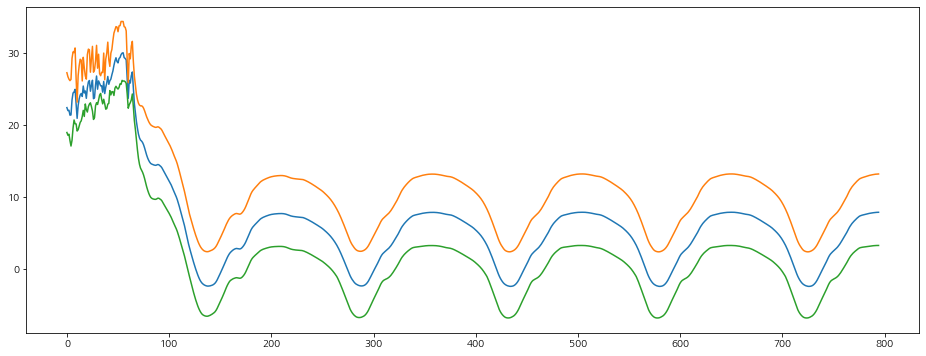

In [46]:
fig, axe = plt.subplots(figsize = (16, 6))
axe.plot(test_pred)